#### This is the Jupyter Notebook to run scVI for Nikita

In [1]:
import scanpy as sc

import warnings
warnings.filterwarnings("ignore")

In [2]:
adata = sc.read_h5ad("/scratch/user/s4543064/xiaohan_pica/data/NRclean_Raw_Data.h5ad")
adata

AnnData object with n_obs × n_vars = 498023 × 15074
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'Technology', 'NR_annotations_simple', 'sample_type_major2', 'cancer_with_H', 'cancer_broadest', 'patient_treatment'
    var: 'name'

In [3]:
import re

adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

sc.pp.highly_variable_genes(adata)
for i in adata.var.index:
    if re.search(i, "^TR[AB][VDJ]|^IG[HKL][VDJC]"):
        adata.var.at[i, "highly_variable"] = False
adata = adata[:, adata.var.highly_variable].copy()

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.umap(adata)

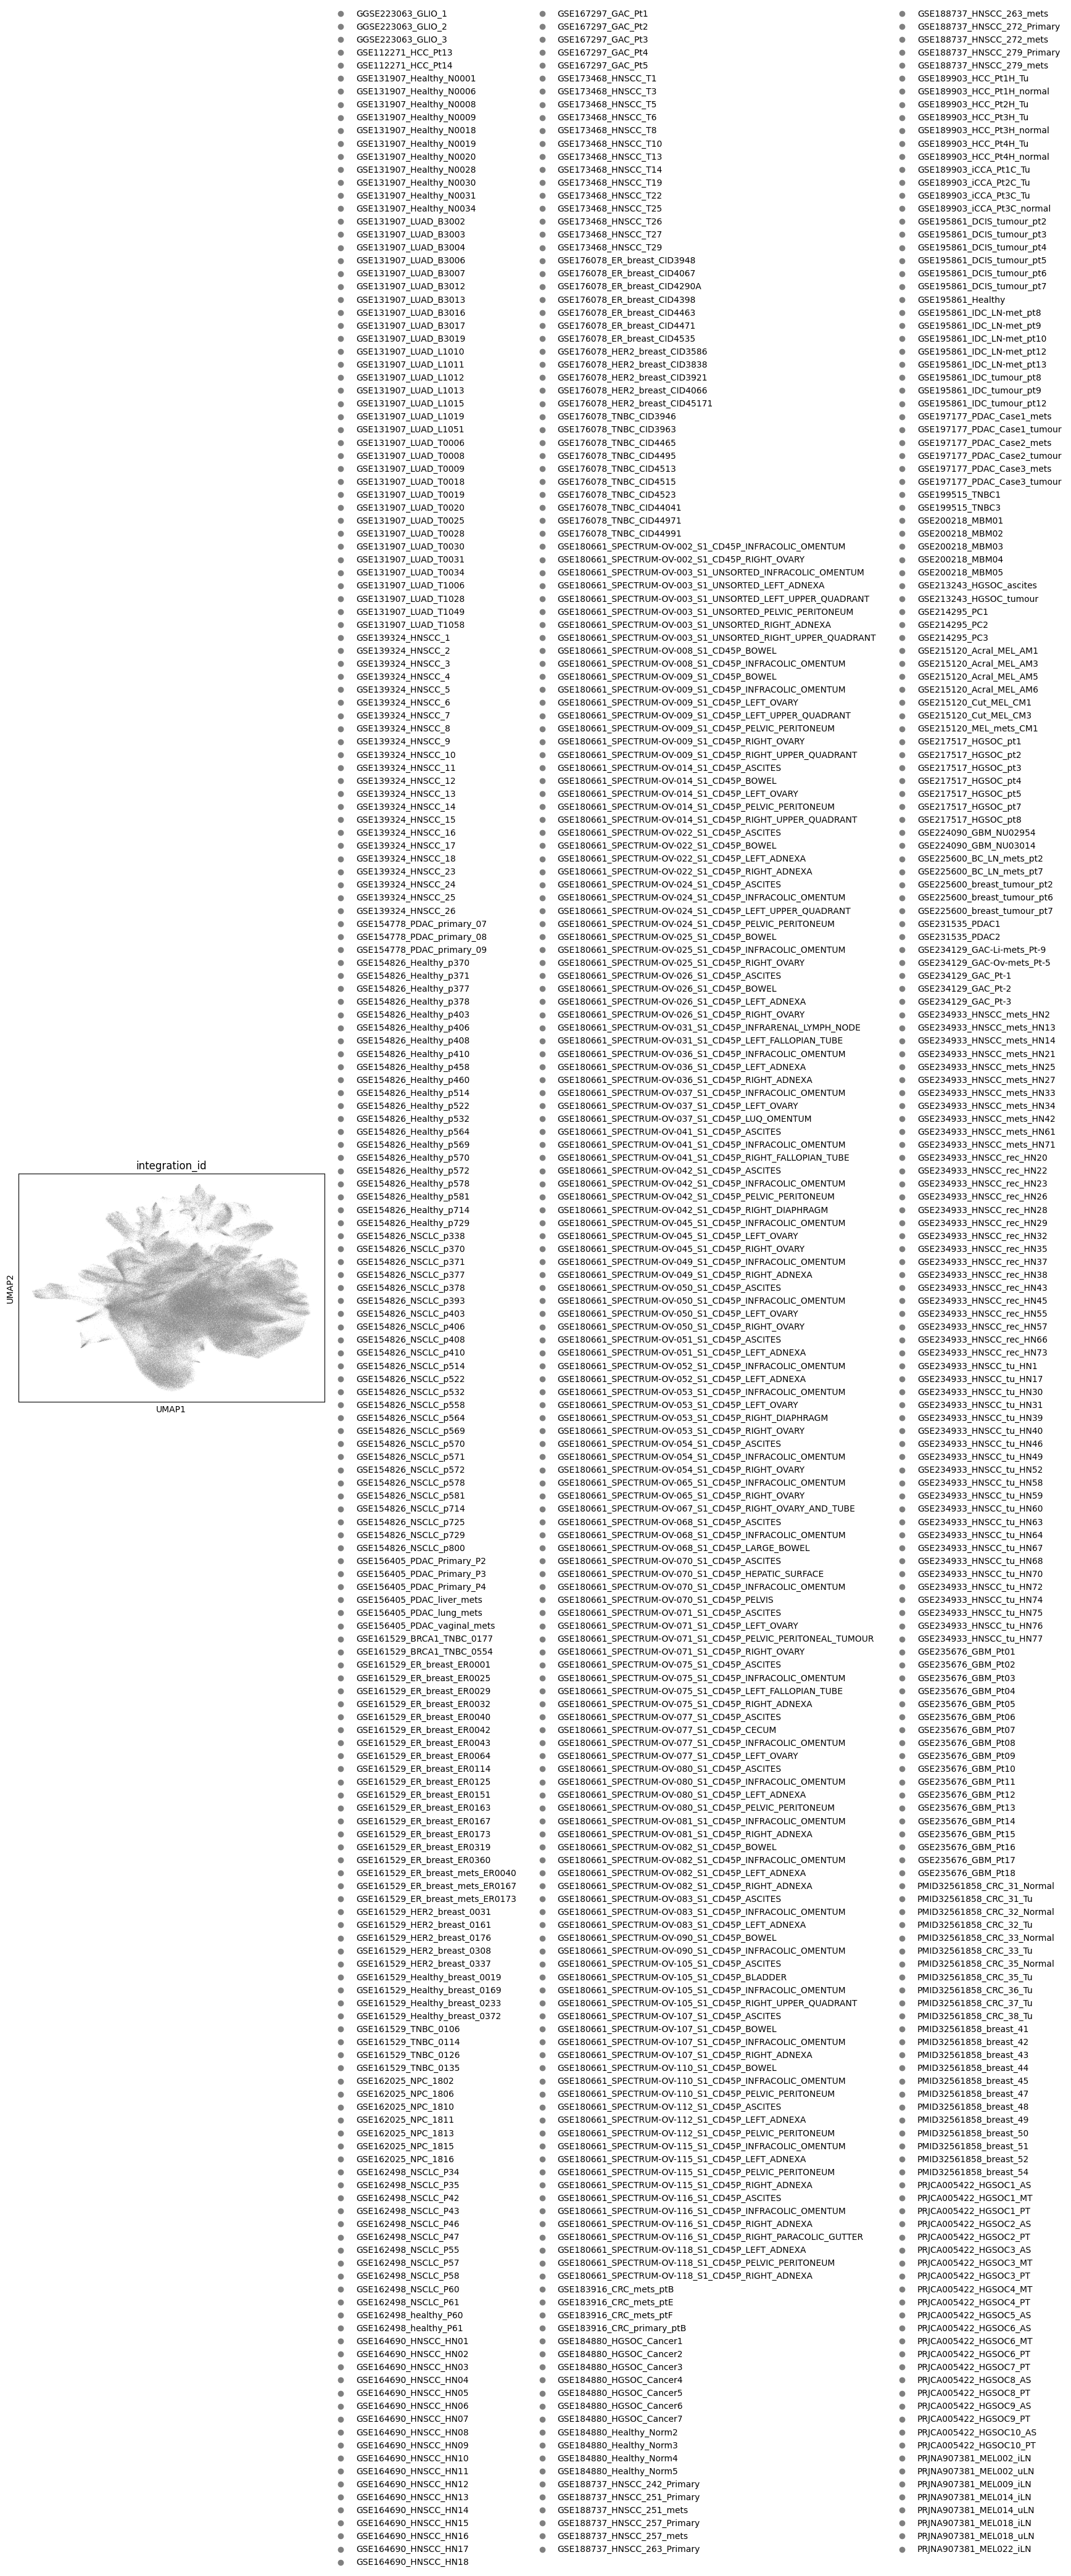

In [4]:
sc.pl.umap(adata, color=['integration_id'])

In [6]:
adata.write_h5ad('/scratch/user/s4543064/xiaohan_pica/write/NRclean_pp.h5ad', compression='gzip')

In [2]:
adata = sc.read_h5ad("/scratch/user/s4543064/xiaohan_pica/write/NRclean_pp.h5ad")

In [3]:
# Run scVI
import scvi

scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="integration_id")
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 16/16: 100%|██████████████████████████████████████████████████████████████████████████| 16/16 [2:30:36<00:00, 576.51s/it, v_num=1, train_loss_step=508, train_loss_epoch=516]

`Trainer.fit` stopped: `max_epochs=16` reached.


Epoch 16/16: 100%|██████████████████████████████████████████████████████████████████████████| 16/16 [2:30:36<00:00, 564.80s/it, v_num=1, train_loss_step=508, train_loss_epoch=516]


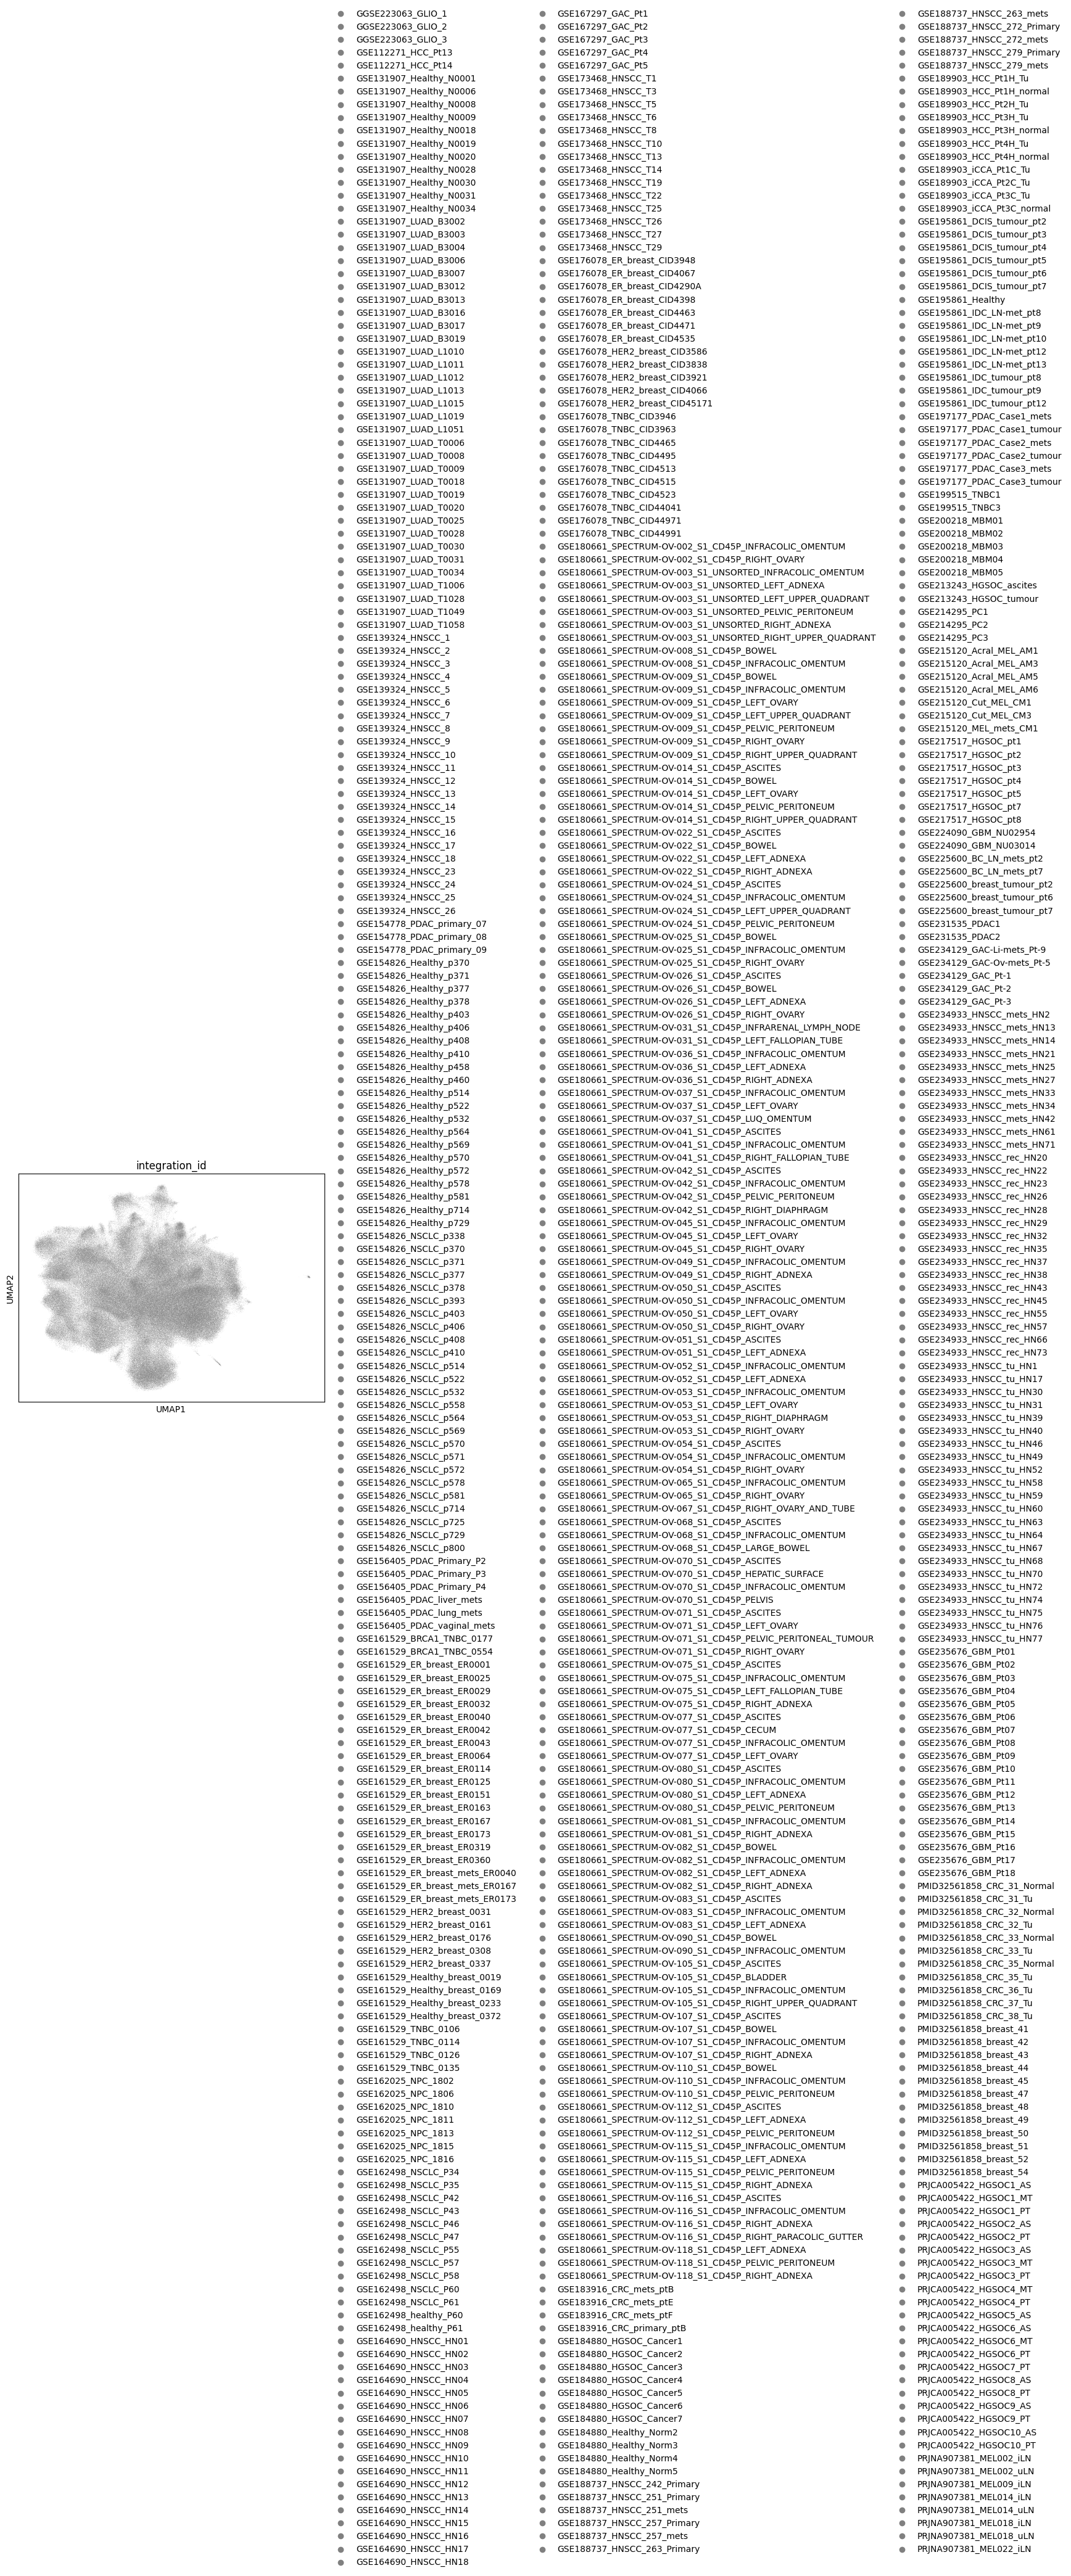

In [4]:
sc.pl.umap(adata, color=['integration_id'])


In [5]:
adata.write_h5ad("/scratch/user/s4543064/xiaohan_pica/write/NRclean_scVI_Data.h5ad", compression='gzip')